# Introduction

This notebook was created by Rohit Satija (rsatija@berkeley.edu) and is part of a series of classification algorithms used in the steaming-hot project for the May 2021 Erdős Institute Data Science BootCamp

# Data 

In [1]:
#For data manipulation
import pandas as pd
import numpy as np

#For plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

In [2]:
data = pd.read_csv('AllData.csv')  # This csv file contains cleaned data of ~10,000 games inlcuding various features
                                   # and mean_player count in the column 'mean'
data = data[data['mean']>1]        # We discard games with mean_player<1 as these represent suspicious games that
                                   # not even the game developer plays
data.shape

(8093, 81)

In [3]:
#Drop columns that are not needed for classification, e.g. Name, App_id, etc
proc_data = data.drop(['App_id','Name','ReleaseDate','Metacritic','SteamSpyOwners', 'SteamSpyOwnersVariance',
                      'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'PriceCurrency','SupportEmail', 
                      'SupportURL', 'AboutText','Background', 'ShortDescrip', 'DetailedDescrip', 'DRMNotice',
                      'ExtUserAcctNotice', 'HeaderImage', 'LegalNotice', 'Reviews','RecommendationCount',
                      'SupportedLanguages', 'Website', 'PCMinReqsText', 'PCRecReqsText',
                      'LinuxMinReqsText', 'LinuxRecReqsText', 'MacMinReqsText','MacRecReqsText',
                      'SteamSpyOwnersNew', 'peak_max', 'peak_mean', 'max'],axis=1)

In [4]:
#This code creates a column called "grade" that one-hot encodes the mean_player count based on popularity
def create_grades(count):
#Return 1 if avg_players>100 and 0 if avg_players<5
        if 100<=count:   
            return 1
        elif count<5:
            return 0
#Return -1 if 5<avg_players<100 in the middle category
        else:
            return -1

proc_data['grade']=proc_data['mean'].apply(create_grades)

#Drop games in the middle category
data_for_classification=proc_data[(proc_data['grade']==0)|(proc_data['grade']==1)]

In [5]:
#Design matrix containing all features
X=data_for_classification.drop(['mean','grade'],axis=1).copy()
X=X.astype(float)

#Target variable: Popularity Grade
y=data_for_classification['grade'].copy()

# Model

In [6]:
#For modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone

#For performance measurement
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [7]:
#Create a train-test split of the design matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y,                
                                                    test_size=0.25,    #75-25 split
                                                    random_state = 42, #Random seed for reproducibility
                                                    shuffle=True,      #Shuffle the data before split
                                                    stratify=y)        #Stratify on the target variable to prevent
                                                                       #class imbalance

In [8]:
#The following code runs a 5-fold stratified cross-validation to optimize the hyperparameter n_neighbors
#in the KNeighborsClassifier routine

#Create a kfold object
kfold = StratifiedKFold(5,shuffle = True,random_state = 42)

#Define maximum n_neighbors to test for
max_neighbors = 50

#Create arrays for accuracy_score, precision_score, recall_score, and f1_score
accs = np.zeros((5,max_neighbors))
prec = np.zeros((5,max_neighbors))
recs = np.zeros((5,max_neighbors))
f1s = np.zeros((5,max_neighbors))

#This is to keep track of the train test split
j = 0

for train_index, test_index in kfold.split(X_train,y_train):
    # Get the cv train test split
    X_train_train, X_train_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_train, y_train_test = y_train.iloc[train_index], y_train.iloc[test_index]
    for i in range(1,max_neighbors+1):
        #Create a model object
        knn = KNeighborsClassifier(i)
        
        #Fit the model
        knn.fit(X_train_train, y_train_train.ravel())
        
        #Predict
        y_pred = knn.predict(X_train_test)
        
        #Measure accuracy, precision, recall, f1
        accs[j,i-1] = accuracy_score(y_train_test,y_pred)
        prec[j,i-1] = precision_score(y_train_test,y_pred)
        recs[j,i-1] = recall_score(y_train_test,y_pred)
        f1s[j,i-1] = f1_score(y_train_test,y_pred)
        
    j=j+1

# Result

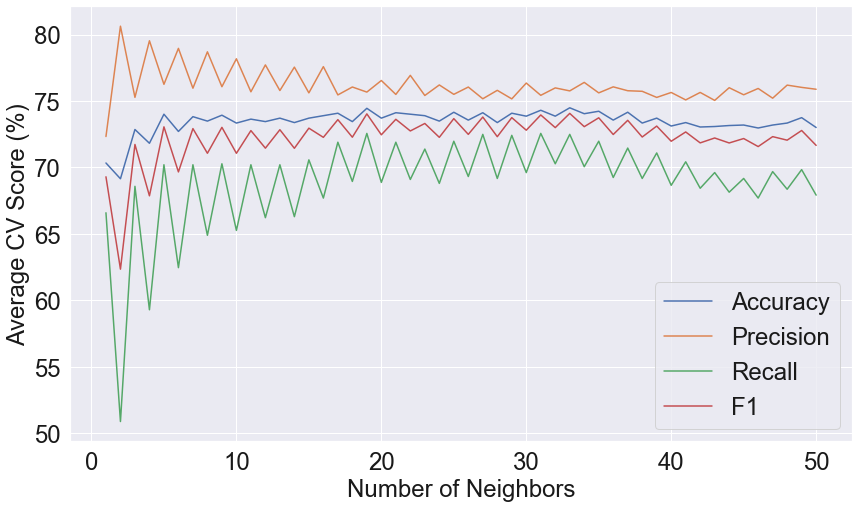

In [9]:
#Plot the result
plt.figure(figsize=(14,8))
fontsize=24
fontcolor='k'

plt.plot(range(1,max_neighbors+1), 100*np.mean(accs, axis=0),label='Accuracy')
plt.plot(range(1,max_neighbors+1), 100*np.mean(prec, axis=0),label='Precision')
plt.plot(range(1,max_neighbors+1), 100*np.mean(recs, axis=0),label='Recall')
plt.plot(range(1,max_neighbors+1), 100*np.mean(f1s, axis=0),label='F1')

plt.xlabel("Number of Neighbors", fontsize=fontsize,color=fontcolor)
plt.ylabel("Average CV Score (%)", fontsize=fontsize,color=fontcolor)

plt.setp(plt.legend(fontsize=fontsize).get_texts(), color=fontcolor)
plt.xticks(fontsize=fontsize,color=fontcolor)
plt.yticks(fontsize=fontsize,color=fontcolor)
plt.show()

In [11]:
# Best accuracy:
knn_best_acc,knn_best_acc_index=(np.max(100*np.mean(accs, axis=0)),np.argmax(100*np.mean(accs, axis=0)))
print('max accuracy:',np.round(knn_best_acc,2),'n_neighbors:',knn_best_acc_index+1)
print()
# Best Precision:
knn_best_prec,knn_best_prec_index=(np.max(100*np.mean(prec, axis=0)),np.argmax(100*np.mean(prec, axis=0)))
print('max precision:',np.round(knn_best_prec,2),'n_neighbors:',knn_best_prec_index+1)
print()
# Best Recall:
knn_best_rec,knn_best_rec_index=(np.max(100*np.mean(recs, axis=0)),np.argmax(100*np.mean(recs, axis=0)))
print('max recall:',np.round(knn_best_rec,2),'n_neighbors:',knn_best_rec_index+1)
print()
# Best F1-score:
knn_best_f1,knn_best_f1_index=(np.max(100*np.mean(f1s, axis=0)),np.argmax(100*np.mean(f1s, axis=0)))
print('max f1-score:',np.round(knn_best_f1,2),'n_neighbors:',knn_best_f1_index+1)
print()

max accuracy: 74.49 n_neighbors: 33

max precision: 80.63 n_neighbors: 2

max recall: 72.56 n_neighbors: 31

max f1-score: 74.07 n_neighbors: 33



It is clear that n_neighbors = 2 gives best precision but poor accuracy, recall, and f-1 scores. Since our model must generally perform well in all metrics, we instead focus on n_neighbors = 33. 

In [12]:
#Let us now train our validated model with n_neighbors=33 on the full training set and calculate performance on 
#test set
knn = KNeighborsClassifier(n_neighbors = knn_best_acc_index+1)

knn.fit(X_train,y_train.ravel())

y_pred = knn.predict(X_test)

print('test accuracy:',np.round(100*accuracy_score(y_test,y_pred),2))
print('test precision:',np.round(100*precision_score(y_test,y_pred),2))
print('test recall:',np.round(100*recall_score(y_test,y_pred),2))
print('test f1-score:',np.round(100*f1_score(y_test,y_pred),2))

test accuracy: 73.78
test precision: 74.94
test recall: 71.96
test f1-score: 73.42


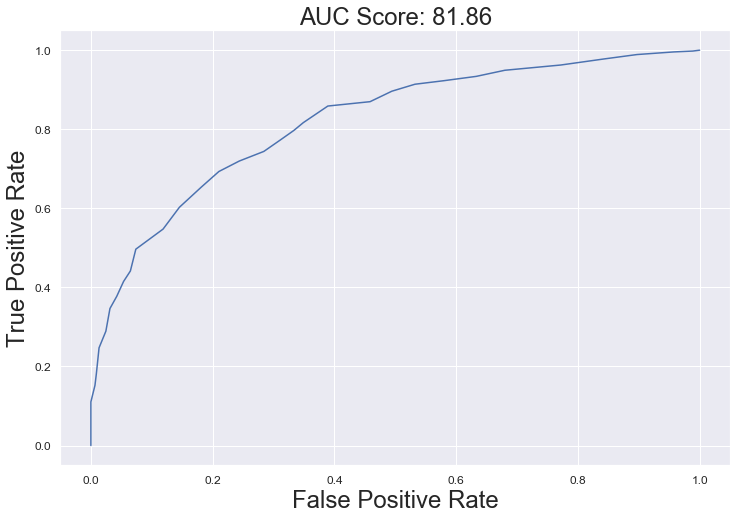

In [13]:
#Plot the ROC curve and calculate the final AUC score on the test set
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = knn.predict_proba(X_test)

fpr,tpr,cutoffs = roc_curve(y_test,probs[:,1])

plt.figure(figsize=(12,8))

plt.plot(fpr,tpr)

plt.title("AUC Score: "+str(np.round(100*roc_auc_score(y_test,probs[:,1]),2)),fontsize=fontsize)
plt.xlabel("False Positive Rate",fontsize=fontsize)
plt.ylabel("True Positive Rate",fontsize=fontsize)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

__That's all folks!__